# ****Import Libraries****

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split
import kagglehub

## ****Set Random Seed****

In [2]:
# Set random seeds for Repoductibility
torch.manual_seed(42)

## ****Check GPU Availability****

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device name :\t{device}')

Device name :	cuda


# ****Import Data****

In [4]:
path = kagglehub.dataset_download("zalando-research/fashionmnist", path = 'fashion-mnist_train.csv')

df = pd.read_csv(path)

# ****Visualization of Data****

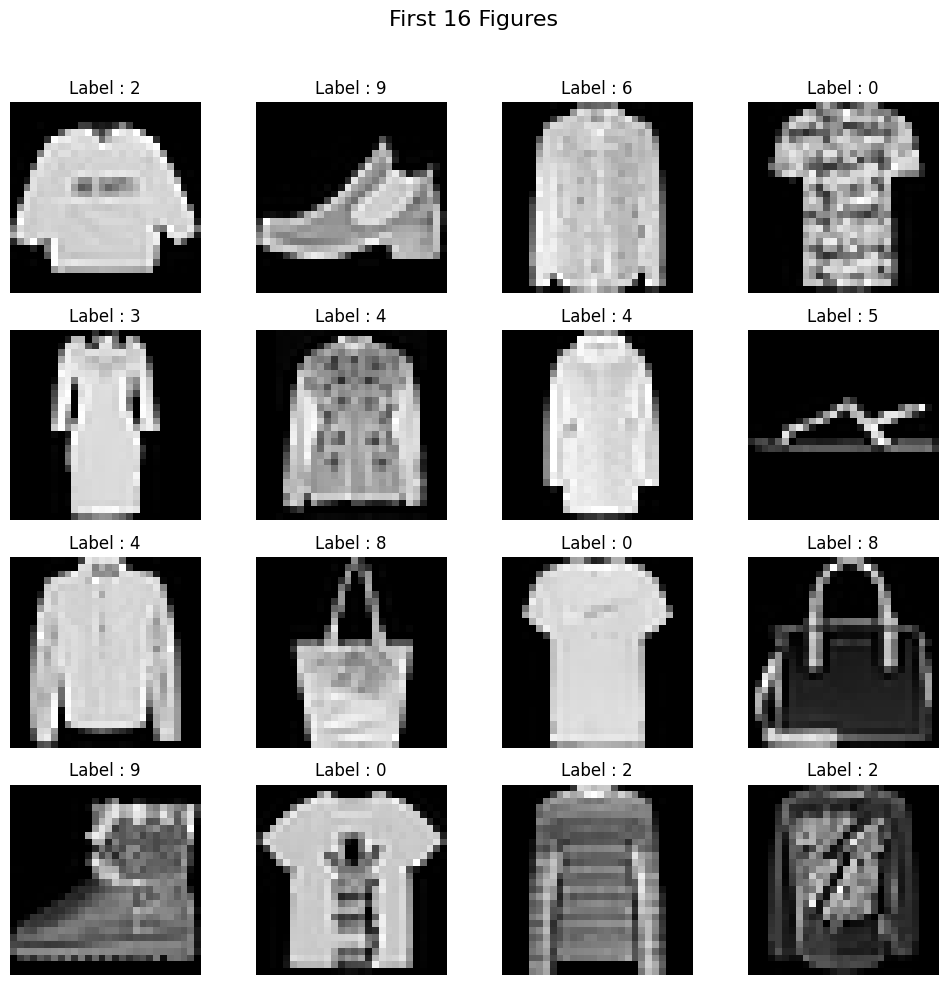

In [5]:
fig, axis = plt.subplots(4, 4, figsize = (10, 10))
fig.suptitle('First 16 Figures', fontsize = 16)                                                           # create 4 x 4 grid of images

for i, ax in enumerate(axis.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28)                                                       # Reshape the data for image plot
  ax.imshow(img, cmap = 'grey')                                                                                          # Display image
  ax.axis('off')                                                                                          # Remove axis
  ax.set_title(f'Label : {df.iloc[i, 0]}')

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

# ****Split Data in Train and test****

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# ****Make Class CustomDataset and use DataLoader****

## ****Dataset****

In [9]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype = torch.float32)
    self.labels = torch.tensor(labels, dtype = torch.long)

  def __len__(self):

    return len(self.features)

  def __getitem__(self, idx):

    return self.features[idx], self.labels[idx]

In [10]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

## ****DataLoader****

In [11]:
train_loader = DataLoader(train_dataset, batch_size = 128, pin_memory = True, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, pin_memory = True, shuffle = False)

# ****Making Neural Network****

In [12]:
from torch.nn.modules.linear import Linear
class MyNN(nn.Module):

  def __init__(self, num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )

  def forward(self, x):

      return self.model(x)

# ****Trainig Model****

In [13]:
learning_rate = 0.0001
epochs = 100

In [14]:
# Instatiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

## ****Trainig with Loop****

In [15]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # Move to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # Forward Pass
    out = model(batch_features)

    # loss Calculation
    loss = criterion(out, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update Grad
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f"Epoch : {epoch + 1}, Loss : {avg_loss: .4f}")

Epoch : 1, Loss :  1.1201
Epoch : 2, Loss :  0.5820
Epoch : 3, Loss :  0.5053
Epoch : 4, Loss :  0.4683
Epoch : 5, Loss :  0.4402
Epoch : 6, Loss :  0.4246
Epoch : 7, Loss :  0.4055
Epoch : 8, Loss :  0.3931
Epoch : 9, Loss :  0.3813
Epoch : 10, Loss :  0.3707
Epoch : 11, Loss :  0.3622
Epoch : 12, Loss :  0.3564
Epoch : 13, Loss :  0.3465
Epoch : 14, Loss :  0.3391
Epoch : 15, Loss :  0.3320
Epoch : 16, Loss :  0.3243
Epoch : 17, Loss :  0.3194
Epoch : 18, Loss :  0.3158
Epoch : 19, Loss :  0.3074
Epoch : 20, Loss :  0.3018
Epoch : 21, Loss :  0.2981
Epoch : 22, Loss :  0.2928
Epoch : 23, Loss :  0.2862
Epoch : 24, Loss :  0.2845
Epoch : 25, Loss :  0.2803
Epoch : 26, Loss :  0.2743
Epoch : 27, Loss :  0.2681
Epoch : 28, Loss :  0.2630
Epoch : 29, Loss :  0.2632
Epoch : 30, Loss :  0.2566
Epoch : 31, Loss :  0.2545
Epoch : 32, Loss :  0.2487
Epoch : 33, Loss :  0.2438
Epoch : 34, Loss :  0.2425
Epoch : 35, Loss :  0.2382
Epoch : 36, Loss :  0.2317
Epoch : 37, Loss :  0.2284
Epoch : 38

# ****Model Evaluation****

In [16]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

## ****Train Evaluation****

In [17]:
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outs = model(batch_features)

        _, preds = torch.max(outs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (preds == batch_labels).sum().item()

print("Train Accuracy : ", correct / total)

Train Accuracy :  0.9879375


## ****Test Evaluation****

In [18]:
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move to GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    out = model(batch_features)

    _, pred = torch.max(out, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (pred == batch_labels).sum().item()

print('Test Accuracy : ', correct / total)

Test Accuracy :  0.8901666666666667
